# <center> PPOL564: DS1 | Foundations <br><br> Coding Discussion 5 <br><br> Solution </center>

In [9]:
import pandas as pd
import sklearn.metrics as m
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

# Instructions

**Can we predict whether someone will vote or not?**

In the discussion folder, you'll find the `turnout.csv` data, which was drawn from the 2012 National Election Survey. The data records the age, eduction level (of total years in school), income, race (caucasian or not), and past voting record (i.e. whether or not the respondent voted in the 2012 Presidential election). The sample is composed of 2000 individual respondents. 

Please break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%). 

Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier must be built from scratch. Do not use a third party ML or statistical package. 

Run your algorithm and see how it predicts on the test data. Use the `sklearn.metrics` library to calculate the predictive accuracy and the area underneath the ROC curve. Finally, plot the ROC curve. 

When completing this answer, be sure to: 

- comment on all your code
- provide a narrative for what you're doing
- summarize your results and findings

# Implementation

In [11]:
dat = pd.read_csv('turnout.csv')

# Break data up into training and test data
train=dat.sample(frac=0.8,random_state=323)
test=dat.drop(train.index)

# Reset the indices for both the train and test
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

# Preview the training data 
train.head()

,id,age,educate,income,vote,white
0,1353,46,9.0,1.8429,0,0
1,122,25,15.0,3.8606,1,1
2,1530,69,17.0,13.3041,1,1
3,162,53,10.0,3.5800,1,1
4,1807,34,16.0,5.4713,1,0


### Answer

In [12]:
import scipy.stats as st # for Normal PDF

First, build out the base classification $Pr(class)$

In [13]:
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

In [14]:
# Class probabilities.
pr_vote1 = vote1.shape[0]/train.shape[0]
pr_vote0 = vote0.shape[0]/train.shape[0]

print(f"""
pr(vote == 1) = {round(pr_vote1,2)}
pr(vote == 0) = {round(pr_vote0,2)}
""")


pr(vote == 1) = 0.74
pr(vote == 0) = 0.26



Then build out the conditional probabilities. The tricky part here is that some of the variables are continuous (education, income, age) and others are dichotomous (white).

There are two ways we could crack this nut. 

1. Collapse all the continuous variables into dichotomous variables and simplify the model.
2. Build out the classifier so that it can deal with both types of values. 

Since Option 1 requires use to throw information away, I'll build out option 2. 

In [15]:
# Let's build up a dictionary with the relevant information 
pred_vals = {}

# We'll supply it with a key that tells us
# 1. The variable name
# 2. The variable state: 0, 1, or -1 (if continuous varible)
# 3. The state of vote (i.e. 0 or 1)

First, calculate the conditional probabilities for the dichotomous variable (`white`)

In [16]:
pred_vals[("white",1,1)] = vote1.query("white==1").shape[0]/vote1.shape[0]
pred_vals[("white",1,0)] = vote0.query("white==1").shape[0]/vote0.shape[0]
pred_vals[("white",0,1)] = vote1.query("white==0").shape[0]/vote1.shape[0]
pred_vals[("white",0,0)] = vote0.query("white==0").shape[0]/vote0.shape[0]
pred_vals

{('white', 1, 1): 0.8761583824768323,
 ('white', 1, 0): 0.7796610169491526,
 ('white', 0, 1): 0.12384161752316765,
 ('white', 0, 0): 0.22033898305084745}

Now, let's calculate the conditional PDFs for the continuous variables. Remember `-1` means it's a continuous variable. This way we can keep track of the value as we process the variables. 

In [17]:
pred_vals[('income',-1,1)] = {'mean':vote1.income.mean(),'sd':vote1.income.std()}
pred_vals[('income',-1,0)] = {'mean':vote0.income.mean(),'sd':vote0.income.std()}
pred_vals[('educate',-1,1)] = {'mean':vote1.educate.mean(),'sd':vote1.educate.std()}
pred_vals[('educate',-1,0)] = {'mean':vote0.educate.mean(),'sd':vote0.educate.std()}
pred_vals[('age',-1,1)] = {'mean':vote1.age.mean(),'sd':vote1.age.std()}
pred_vals[('age',-1,0)] = {'mean':vote0.age.mean(),'sd':vote0.age.std()}
pred_vals

{('white', 1, 1): 0.8761583824768323,
 ('white', 1, 0): 0.7796610169491526,
 ('white', 0, 1): 0.12384161752316765,
 ('white', 0, 0): 0.22033898305084745,
 ('income', -1, 1): {'mean': 4.258665796124684, 'sd': 2.9009783277578696},
 ('income', -1, 0): {'mean': 2.8083740920096854, 'sd': 2.2222018360245834},
 ('educate', -1, 1): {'mean': 12.59519797809604, 'sd': 3.2493017317689734},
 ('educate', -1, 0): {'mean': 10.665859564164649, 'sd': 3.2326417027391328},
 ('age', -1, 1): {'mean': 46.14827295703454, 'sd': 16.76013458371937},
 ('age', -1, 0): {'mean': 42.653753026634384, 'sd': 19.127668078553697}}

Now let's build a function where we loop through all the values of the data and make a prediction.

In [18]:
def predict(data,pred_vals):
    '''
    Build out a naive Bayesian classifier.
    
    The data input assumes the outcome is not contained within. 
    '''
    store_preds = []
    
    for i,row in data.iterrows():
        
        pr_0 = 1; pr_1 = 1 # Starter values
        
        for j in range(0,len(row)):
            
            # If it's the outcome or id go to the next position in the index
            if row.index[j] in ["vote","id"]:
                continue  
            # If dichotomous, go here
            elif row.index[j] == "white":
                pr_0 *= pred_vals[(row.index[j],row.values[j],0)]
                pr_1 *= pred_vals[(row.index[j],row.values[j],1)]   
            # else it's continuous 
            else:  
                pr_0 *= st.norm(pred_vals[(row.index[j],-1,0)]['mean'],
                                pred_vals[(row.index[j],-1,0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(pred_vals[(row.index[j],-1,1)]['mean'], 
                                pred_vals[(row.index[j],-1,1)]['sd']).pdf(row.values[j])
                
            
        # Multiply in the base class.
        pr_0 *= pr_vote0
        pr_1 *= pr_vote1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

Run the algorithm

In [19]:
preds_train = predict(train,pred_vals)

Let's look at our in-sample performance.

In [20]:
round(sum(train.vote == preds_train.pred)/train.shape[0],2)

0.74

Let's now look at the out-of-sample performance.

In [21]:
preds_test = predict(test,pred_vals)

Calculate the Accuracy and the ROC AUC.

In [28]:
# Accuracy
m.accuracy_score(test['vote'],preds_test.pred)

0.72

In [29]:
m.roc_auc_score(test['vote'],preds_test.pr_1)

0.5301294219154443

Plot the ROC Curve

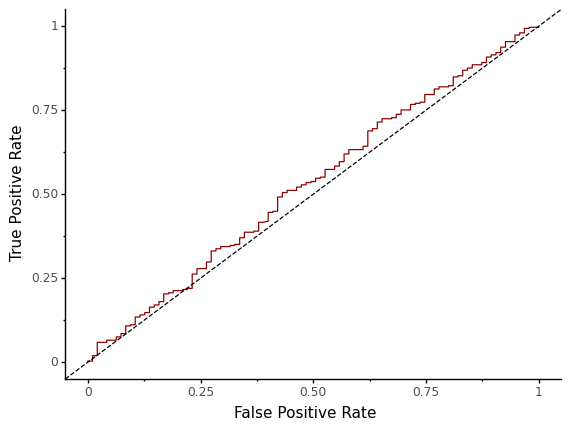

<ggplot: (-9223363269977197708)>

In [36]:
fpr,tpr,thres = m.roc_curve(test['vote'],preds_test.pr_1)

(
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="darkred") +
    geom_abline(linetype="dashed") +
    theme_classic() +
    labs(y="True Positive Rate",x="False Positive Rate")
)